In [29]:
%matplotlib inline

import sys
import json
import math
import numpy as np
import matplotlib.cm as cm
from pprint import pprint as pp
from matplotlib import pyplot as plt

MIN = sys.float_info.min
MAX = sys.float_info.max

In [30]:
class Point:
    def __init__(self, x, y, force, aziang, altang, time):
        self.x = x
        self.y = y
        self.force = force
        self.aziang = aziang
        self.altang = altang
        self.time = time
    
    def __str__(self):
        return "({0}, {1})".format(self.x, self.y)
    
    def __repr__(self):
        return self.__str__()

class Stroke:
    def __init__(self):
        self.points = []
        self.order = -1
        self.max_x = MIN
        self.min_x = MAX
        self.max_y = MIN
        self.min_y = MAX
        self.area = 0.0
        self.length = 0
        # Add more parameters/features
        
    def __str__(self):
        return "({0}, {1}, {2})".format(self.order, len(self.points), self.area)
    
    def __repr__(self):
        return self.__str__()
    
    def add_point(self, point):
        self.points.append(point)
    
    #For plotting
    def get_coordinates(self, invertY = True):
        x_coords = []
        y_coords = []
        for point in self.points:
            x_coords.append(point.x)
            y_coords.append(-point.y if invertY else point.y)
        
        return x_coords, y_coords
    
    def toJSON(self):
        return json.dumps(self, default=lambda o: o.__dict__, 
            sort_keys=True, indent=4)
              
class Drawing:
    def __init__(self):
        self.strokes = []
        # Other parameters...
        
    def __str__(self):
        return "({0})".format(len(self.strokes))
    
    def __repr__(self):
        return self.__str__()
    
    def add_stroke(self, stroke):
        self.strokes.append(stroke)
        
    def get_stroke(self, order):
        stroke_by_index = self.strokes[order]
        if stroke_by_index.order == order:
            return stroke_by_index
        else:
            print "Order ({0}) is not the same as index ({1})!".format(order, stroke_by_index.order)
            for stroke in self.strokes:
                if stroke.order == order:
                    return stroke
            # throw exception?
            
    def get_borders(self):
        max_x = MIN
        max_x_stroke = -1
        min_x = MAX
        min_x_stroke = -1
        max_y = MIN
        max_y_stroke = -1
        min_y = MAX
        min_y_stroke = -1
        
        for stroke in self.strokes:
            if stroke.max_x > max_x:
                max_x = stroke.max_x
                max_x_stroke = stroke.order
            
            if stroke.max_y > max_y:
                max_y = stroke.max_y
                max_y_stroke = stroke.order
                
            if stroke.min_x < min_x:
                min_x = stroke.min_x
                min_x_stroke = stroke.order
                
            if stroke.min_y < min_y:
                min_y = stroke.min_y
                min_y_stroke = stroke.order
        
        return max_x, max_x_stroke, min_x,min_x_stroke, max_y, max_y_stroke, min_y, min_y_stroke
            
                
class Helper:
    
    @staticmethod
    def euclidean_distance(p, q):
        return math.sqrt((q.x - p.x)**2 + (q.y - p.y)**2)
    
    @staticmethod
    def quadrant(center, p):
        if p.x >= center.x and p.y > center.y:
            return 1
        
        if p.x > center.x and p.y <= center.y:
            return 2
        
        if p.x <= center.x and p.y < center.y:
            return 3
        
        if p.x < center.x and p.y >= center.y:
            return 4
        
    @staticmethod
    def direction(full_direction):
        #todo: maybe regexp?
        if full_direction in "1234123412341234123412341234":
            return "CCW"
        
        if full_direction in "4321432143214321432143214321":
            return "CW"
        
        return "UNKNOWN" # ???

In [31]:
with open('../clock-data/clock-3-ipad.json') as json_file:
    json_data = json.load(json_file)
    
json_strokes = []
for i in range(0, len(json_data["data"])):
    json_strokes.append(json_data["data"][i])

drawing = Drawing()        

for index, json_stroke in enumerate(json_strokes):
    
    stroke = Stroke()
    
    for json_point in json_stroke:
        if json_point["x"] > stroke.max_x:
            stroke.max_x = json_point["x"]
        if json_point["x"] < stroke.min_x:
            stroke.min_x = json_point["x"]
        if json_point["y"] > stroke.max_y:
            stroke.max_y = json_point["y"]
        if json_point["y"] < stroke.min_y:
            stroke.min_y = json_point["y"]
        
        stroke.add_point(Point(json_point["x"], json_point["y"], json_point["force"], json_point["aziang"], json_point["altang"], json_point["time"]))
    
    stroke.order = index
    stroke.width = stroke.max_x - stroke.min_x
    stroke.height = stroke.max_y - stroke.min_y
    stroke.area = stroke.width * stroke.height
    stroke.length = len(stroke.points)
    
    #TODO: Extract more features
    
    drawing.add_stroke(stroke)
    
print "Number of strokes: {}".format(len(drawing.strokes))
        

Number of strokes: 21


In [32]:
x_coords = []
y_coords = []     

plt.style.use('ggplot')
plt.figure(figsize=(6,5))

for stroke in drawing.strokes:
    for point in stroke.points:
        x_coords.append(point.x)
        y_coords.append(-point.y)
    plt.scatter(x_coords, y_coords, c=np.random.rand(3,1))
    x_coords=[]
    y_coords=[]


# plt.scatter(x_coords, y_coords)
plt.grid()
plt.show()

#### How can i classify 5, 7, 4 as a single stroke?  
* Using average "size" or "length" of a strokes (without circle) to find "small strokes" and attach them to closest stroke
* Use combinations of strokes (overlapping, close to each other)

#### How can i classify 10, 11, 12 as a single stroke?
* Positioning (quadrant) + they're close and almost on the same height?
* Clustering?

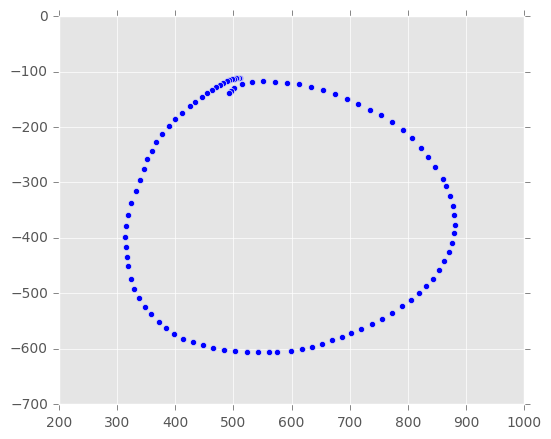

x_max: 880.5, y_max: 607, x_min: 314, y_min: 111


x_max: 544, y_max: 199.5, x_min: 541.5, y_min: 153


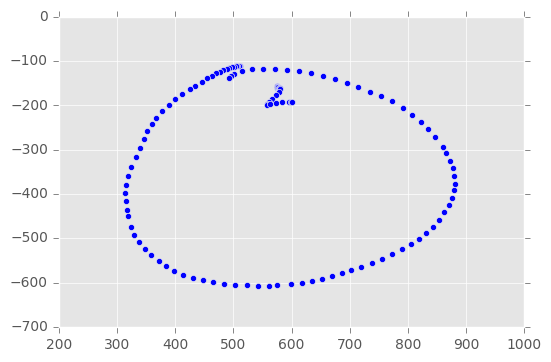

x_max: 600.5, y_max: 198, x_min: 557, y_min: 156.5


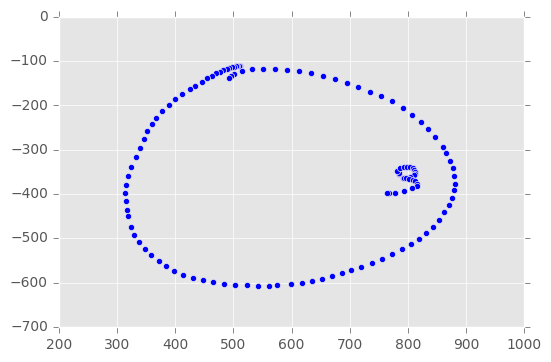

x_max: 816.5, y_max: 398, x_min: 764, y_min: 339.5


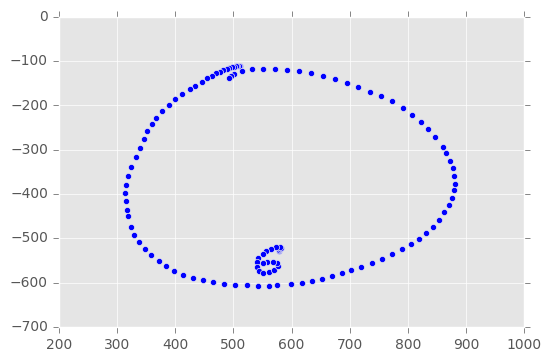

x_max: 582, y_max: 577.5, x_min: 540, y_min: 519.5


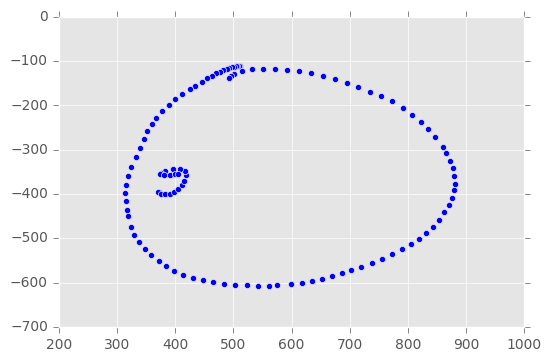

x_max: 418.5, y_max: 400.5, x_min: 370, y_min: 343.5


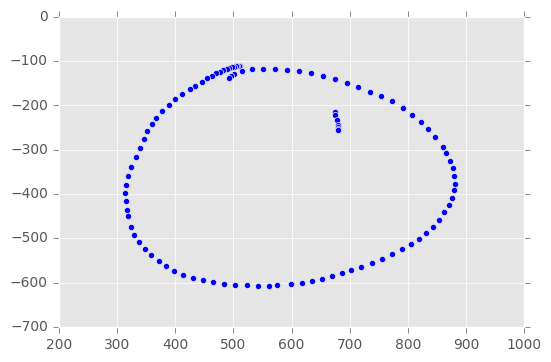

x_max: 680, y_max: 254.5, x_min: 674, y_min: 214.5


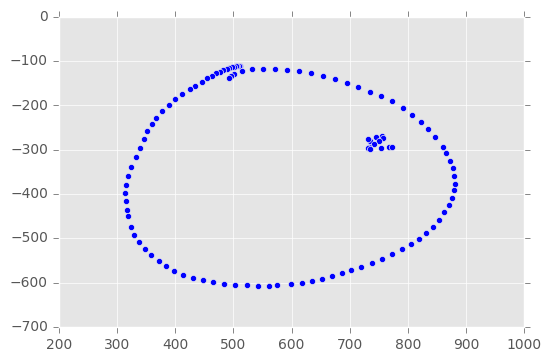

x_max: 772, y_max: 298, x_min: 732, y_min: 270


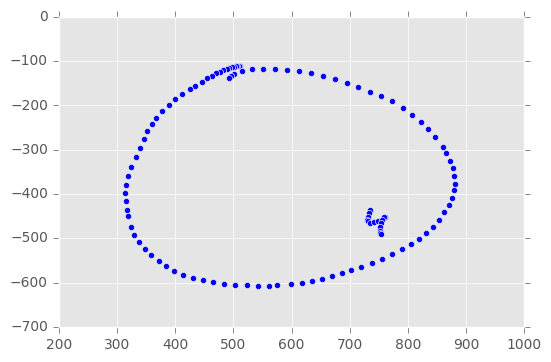

x_max: 761, y_max: 489.5, x_min: 730.5, y_min: 435.5


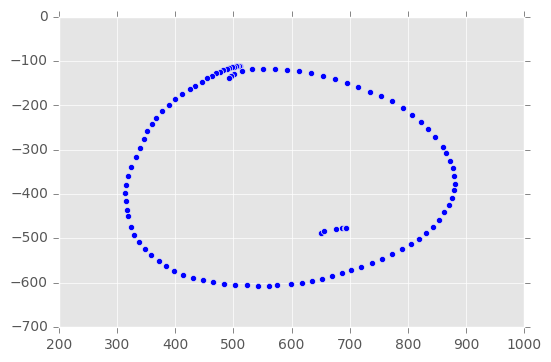

x_max: 694, y_max: 488.5, x_min: 650.5, y_min: 476


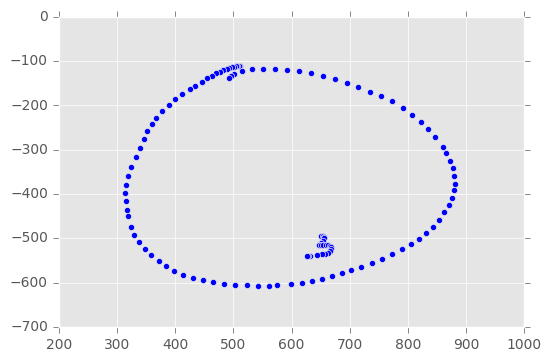

x_max: 667, y_max: 540, x_min: 626, y_min: 494


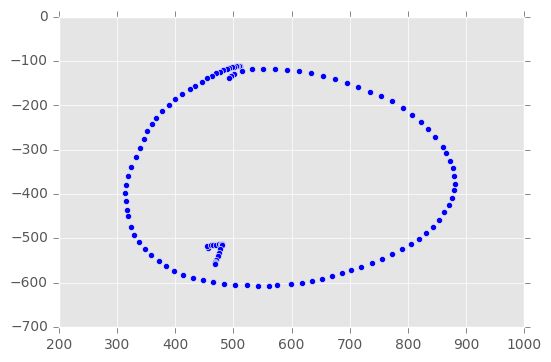

x_max: 480.5, y_max: 557, x_min: 455, y_min: 512.5


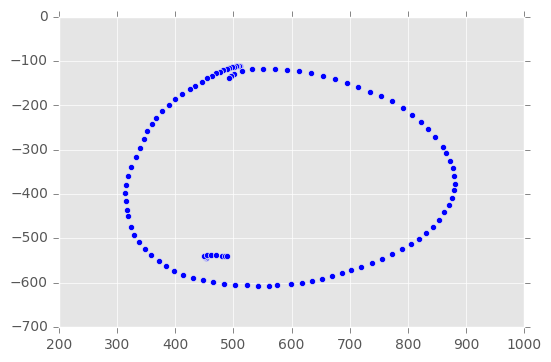

x_max: 488.5, y_max: 544, x_min: 449.5, y_min: 537


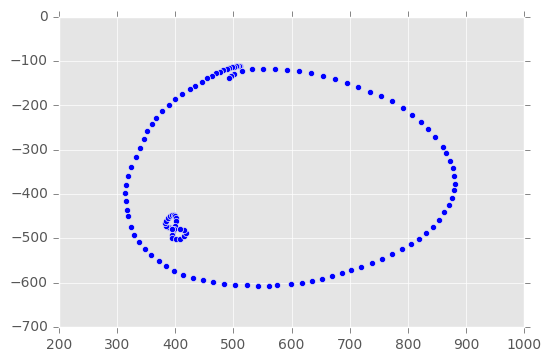

x_max: 418, y_max: 502.5, x_min: 382, y_min: 447


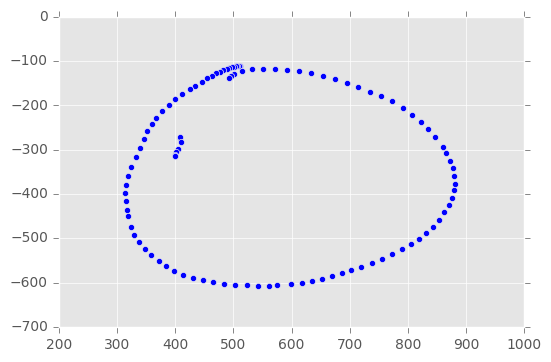

x_max: 409.5, y_max: 315, x_min: 399.5, y_min: 271.5


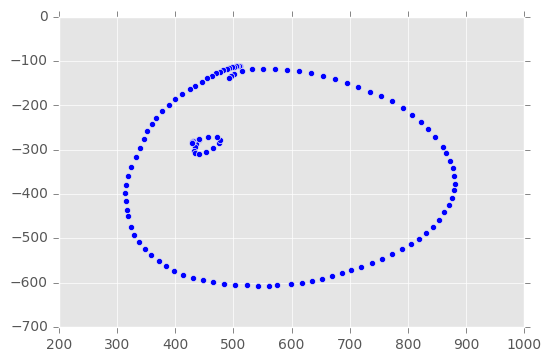

x_max: 477.5, y_max: 309.5, x_min: 428.5, y_min: 271


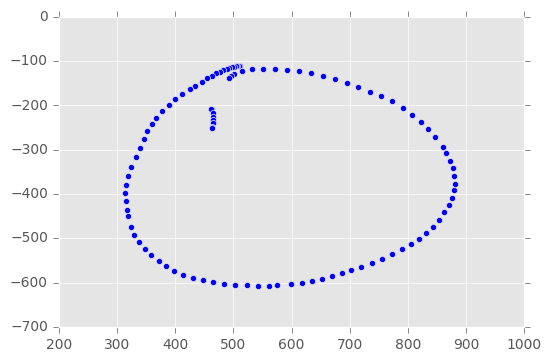

x_max: 465, y_max: 252, x_min: 462, y_min: 208


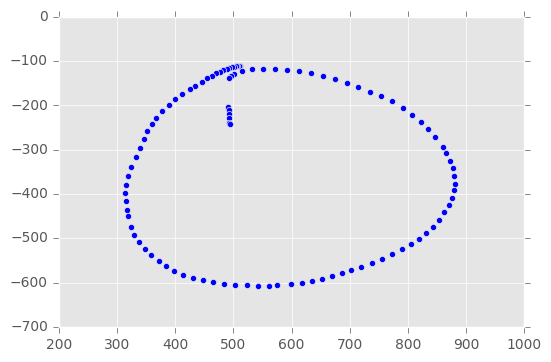

x_max: 493.5, y_max: 242.5, x_min: 490, y_min: 204


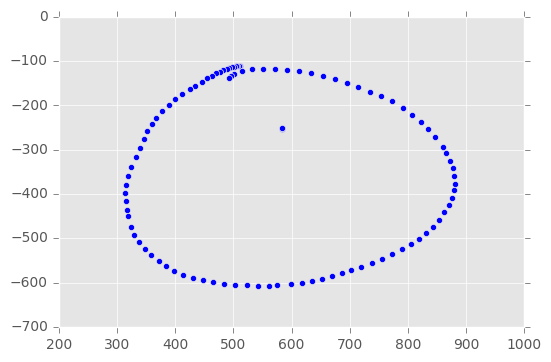

x_max: 583.5, y_max: 252.5, x_min: 583, y_min: 251


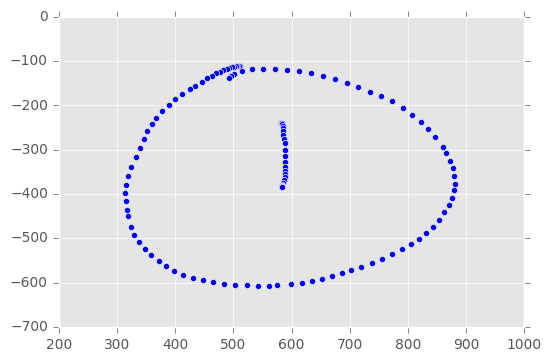

x_max: 589, y_max: 383, x_min: 582.5, y_min: 240


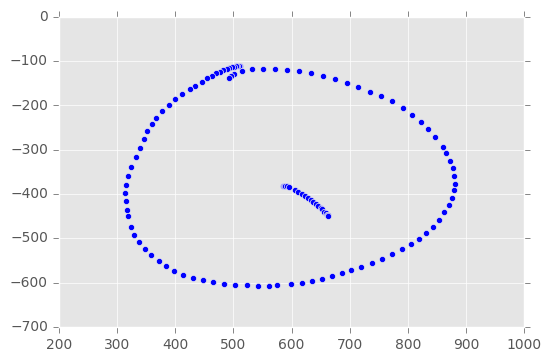

x_max: 662.5, y_max: 449, x_min: 586, y_min: 382


In [37]:
plt.style.use('ggplot')
plt.figure(figsize=(6,5))

circle = drawing.strokes[0]
circle_x, circle_y = circle.get_coordinates()

for stroke in drawing.strokes:
    x_coords, y_coords = stroke.get_coordinates()
    plt.scatter(circle_x, circle_y)
    plt.scatter(x_coords, y_coords)
    plt.show()
    print "x_max: {}, y_max: {}, x_min: {}, y_min: {}".format(stroke.max_x, stroke.max_y, stroke.min_x, stroke.min_y)